In [27]:
%pip install pandas matplotlib seaborn scikit-learn xgboost --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
#import the dataset
df = pd.read_csv('dataset.csv')
#check for nulls in columns
print(df.isnull().sum())

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


In [4]:
#The nulls are only names, so we can drop them without concerns
df.dropna(subset=["artists","album_name","track_name"] )
print(df.describe())


          Unnamed: 0     popularity   duration_ms   danceability  \
count  114000.000000  114000.000000  1.140000e+05  114000.000000   
mean    56999.500000      33.238535  2.280292e+05       0.566800   
std     32909.109681      22.305078  1.072977e+05       0.173542   
min         0.000000       0.000000  0.000000e+00       0.000000   
25%     28499.750000      17.000000  1.740660e+05       0.456000   
50%     56999.500000      35.000000  2.129060e+05       0.580000   
75%     85499.250000      50.000000  2.615060e+05       0.695000   
max    113999.000000     100.000000  5.237295e+06       0.985000   

              energy            key       loudness           mode  \
count  114000.000000  114000.000000  114000.000000  114000.000000   
mean        0.641383       5.309140      -8.258960       0.637553   
std         0.251529       3.559987       5.029337       0.480709   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.472000       2.000000     -1

In [5]:
#drop songs that are less than 30s - they are meaningless
df = df[df["duration_ms"]>= 30000]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 113983 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        113983 non-null  int64  
 1   track_id          113983 non-null  object 
 2   artists           113983 non-null  object 
 3   album_name        113983 non-null  object 
 4   track_name        113983 non-null  object 
 5   popularity        113983 non-null  int64  
 6   duration_ms       113983 non-null  int64  
 7   explicit          113983 non-null  bool   
 8   danceability      113983 non-null  float64
 9   energy            113983 non-null  float64
 10  key               113983 non-null  int64  
 11  loudness          113983 non-null  float64
 12  mode              113983 non-null  int64  
 13  speechiness       113983 non-null  float64
 14  acousticness      113983 non-null  float64
 15  instrumentalness  113983 non-null  float64
 16  liveness          113983 

2. Exploratory Data Analysis

<Axes: xlabel='popularity', ylabel='Count'>

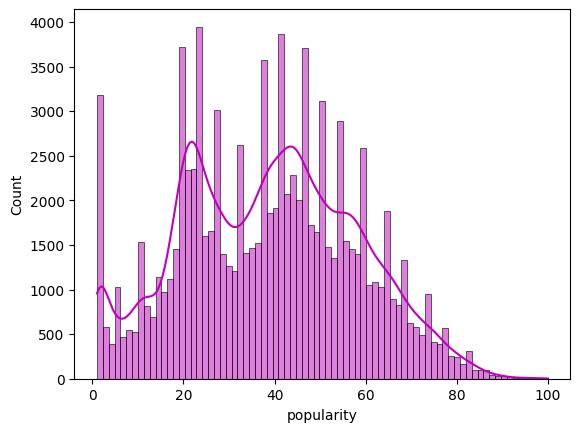

In [6]:
non_zero_popularity = df[df["popularity"] > 0]

sns.histplot(non_zero_popularity["popularity"],kde=True,color="m")


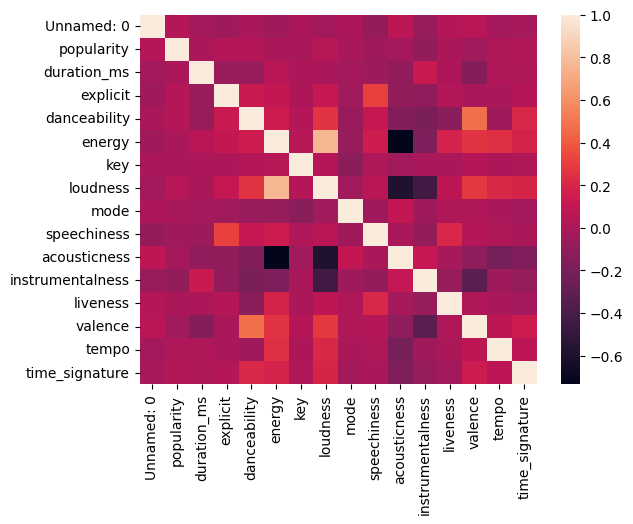

In [7]:
heatplot = sns.heatmap(df.corr(numeric_only=True))

<Axes: xlabel='track_genre', ylabel='popularity'>

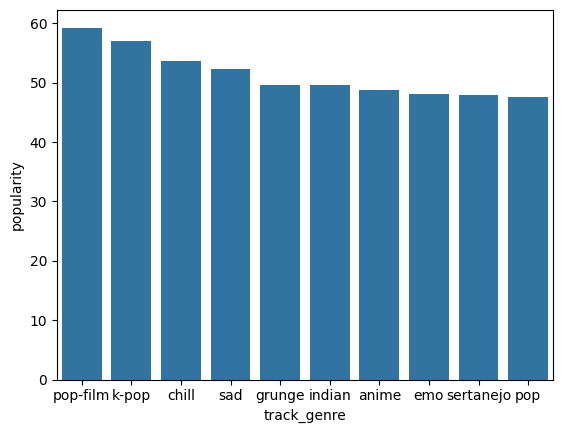

In [8]:
#Visualize the top 10 genres by average popularity using bar charts.

top_10 = df.groupby("track_genre")["popularity"].mean().sort_values(ascending=False).head(10)

sns.barplot(top_10)

3. Feature Engineering

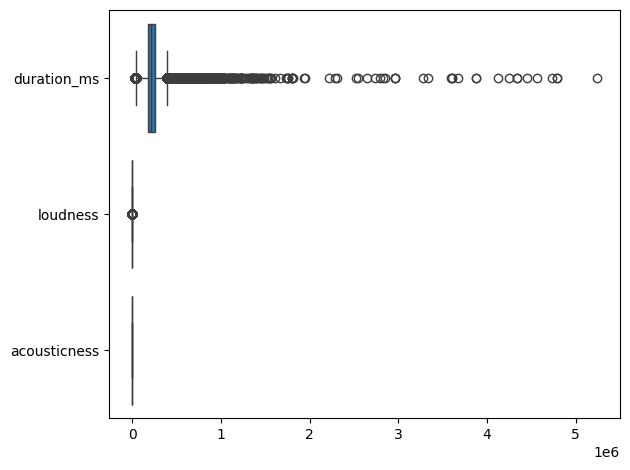

In [39]:
#Are there outliers?
sns.boxplot(data=df[['duration_ms', 'loudness', 'acousticness']], orient='h')
plt.tight_layout()
plt.show()


In [ ]:
#Eliminate the outliers

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

# Remove outliers from duration_ms column
# Pass column name as string, not the Series itself
df_clean = remove_outliers(df, 'duration_ms')

df_clean = remove_outliers(df, df['duration_ms'])

KeyError: "None of [Index([230666, 149610, 210826, 201933, 198853, 214240, 229400, 242946, 189613,\n       205594,\n       ...\n       369049, 250629, 312566, 256026, 305454, 384999, 385000, 271466, 283893,\n       241826],\n      dtype='int64', length=113983)] are in the [columns]"

In [10]:
#one-hot encoding of the musical genres
df_encoded = df.copy()


#boolean to int
boolean_columns = df.select_dtypes(include=[bool]).columns.tolist()
for c in boolean_columns:
    df_encoded[c] = df_encoded[c].astype(int)

cat_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()

cardinality = {}
for c in cat_cols:
    count = df_encoded[c].nunique()
    cardinality[c] = count

low_card_cols = [] # Initialize empty list
threshold = 50
for c, n in cardinality.items():
    if n <= threshold: # The check
        low_card_cols.append(c) # The add


categorical_features = pd.get_dummies(df_encoded, columns=low_card_cols, drop_first=True)

In [11]:
#creating new variable - engagement_score that combines danceability and energe score


df_encoded["engagement_score"] = df["energy"] + df["danceability"]

print(df_encoded["engagement_score"])

0         1.1370
1         0.5860
2         0.7970
3         0.3256
4         1.0610
           ...  
113995    0.4070
113996    0.2910
113997    0.9580
113998    1.0930
113999    1.0130
Name: engagement_score, Length: 113983, dtype: float64


4. Machine Learning


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#only select numerical values - int and float
y = df_encoded['popularity']
x = df_encoded.select_dtypes(include=['number']).drop('popularity', axis=1)

# drop unnamed index column if present (handles both 'Unnamed: 0' and 'Unnamed:0')
x = x.drop(columns=['Unnamed: 0', 'Unnamed:0'], errors='ignore')


#split training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, train_size=0.8, random_state=42)


#scale the data
scalar = StandardScaler()

x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)


#First, we use a linear regression
from sklearn.linear_model import LinearRegression
LinReg = LinearRegression()

# fit on the training set
LinReg.fit(x_train, y_train)


y_pred_Lin = LinReg.predict(x_test)

print(y_pred_Lin)


from sklearn.metrics import mean_squared_error

def RMSE (y_test, y_pred_Lin):
    mse_Lin = mean_squared_error(y_test,y_pred_Lin)
    rmse_Lin = np.sqrt(mse_Lin)
    print(rmse_Lin)


[34.09668093 32.1368352  33.59857178 ... 33.71830137 38.69397421
 30.86483127]


In [32]:
#Hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=100, random_state=42)

# 1. Define a wider range of parameters
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 2. Initialize Random Search
# n_iter=50 means "Try 50 random combinations"
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter=5, cv=3, verbose=2, random_state=42, n_jobs=-1)

# 3. Fit
rf_random.fit(x_train, y_train)

# 4. View Best Parameters
print(rf_random.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.0min
[CV] END max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.0min
[CV] END max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.9min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 9.5min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 9.5min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 9.6min
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 9.8min
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 9.9min
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 2.6min
[CV] END max_depth=50, min_samp

In [33]:
#putting in the parameter

rf = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf= 1, max_depth= 40)

rf.fit(x_train,y_train)

y_pred_rf = rf.predict(x_test)

RMSE(y_test, y_pred_rf)



15.065523648557283


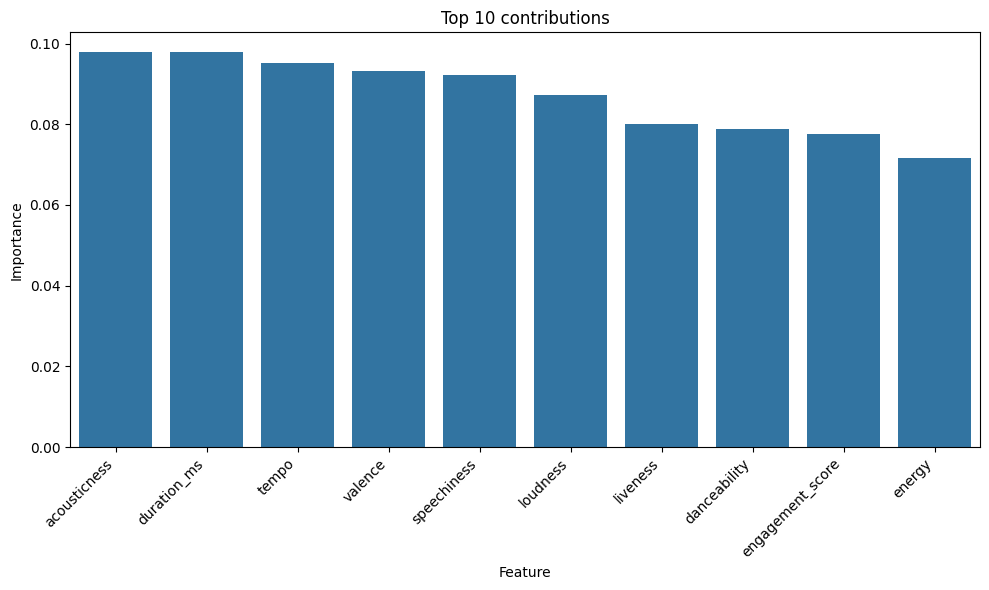

In [ ]:
#Which feature contributes the most?


contribution = rf.feature_importances_
feature_names = x.columns

feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': contribution})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Feature', y='Importance', data=feature_df)
ax.set_title("Top 10 contributions")
plt.xticks(rotation=45, ha='right')   # rotate + align
plt.tight_layout()                     # shrink margins to fit

In [ ]:
#Try XGBoost Model



from xgboost import XGBRegressor


xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(x_train, y_train)

y_pred_xgb = xgb_model.predict(x_test)
RMSE(y_test, y_pred_xgb)

19.218405421199588


## 5. Ways to Reduce Model Error

Here are comprehensive strategies to improve model performance:


### Strategy 1: Enhanced Feature Engineering

**Create more domain-specific features:**
1. **Interaction Features**: Multiply or divide related features (e.g., energy * loudness, tempo / duration_ms)
2. **Polynomial Features**: Create squared/cubed versions of important features
3. **Ratio Features**: Create ratios between features (e.g., speechiness / (speechiness + instrumentalness))
4. **Binning**: Convert continuous variables to categorical bins
5. **Time-based features**: Extract features from duration_ms (minutes, seconds, etc.)

**Example features to create:**
- `energy_loudness_interaction = energy * (loudness + 60) / 60`  # Normalize loudness first
- `danceability_energy_ratio = danceability / (energy + 0.001)`  # Avoid division by zero
- `tempo_bpm_category = pd.cut(tempo, bins=[0, 100, 120, 140, 180, 300], labels=['Slow', 'Moderate', 'Fast', 'Very Fast', 'Extreme'])`
- `duration_minutes = duration_ms / 60000`
- `speechiness_acousticness_ratio = speechiness / (acousticness + 0.001)`


### Strategy 2: Outlier Handling

**Why it matters:** Outliers can skew model predictions and inflate error metrics.

**Methods:**
1. **IQR Method**: Remove or cap values outside Q1 - 1.5*IQR and Q3 + 1.5*IQR
2. **Z-score Method**: Remove values with |z-score| > 3
3. **Cap extreme values**: Set maximum/minimum thresholds based on domain knowledge
4. **Transform skewed features**: Use log transformation for highly skewed distributions

**Features likely to have outliers:**
- `duration_ms` (very long songs)
- `tempo` (very fast/slow songs)
- `loudness` (extreme values)


### Strategy 3: Hyperparameter Tuning

**Current Random Forest uses default parameters.** Fine-tuning can significantly improve performance.

**Use GridSearchCV or RandomizedSearchCV to optimize:**
- `n_estimators`: Number of trees (try 100, 200, 500, 1000)
- `max_depth`: Maximum depth of trees (try 10, 20, 30, None)
- `min_samples_split`: Minimum samples to split (try 2, 5, 10)
- `min_samples_leaf`: Minimum samples per leaf (try 1, 2, 4)
- `max_features`: Features to consider for split (try 'sqrt', 'log2', 0.3, 0.5)
- `bootstrap`: Whether to use bootstrap samples (True/False)

**Example using RandomizedSearchCV:**
```python
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5]
}

rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
```


### Strategy 4: Try Advanced Models

**Current models:** Linear Regression and Random Forest

**Try these more powerful algorithms:**

1. **Gradient Boosting (XGBoost, LightGBM, CatBoost)**
   - Often outperforms Random Forest
   - Handles non-linear relationships better
   - Built-in regularization

2. **Support Vector Regression (SVR)**
   - Good for non-linear patterns
   - Works well with scaled features

3. **Neural Networks**
   - Deep learning can capture complex patterns
   - Requires more data and computation

4. **Ensemble Methods**
   - Combine multiple models (voting, stacking)
   - Often achieves best performance

**Example XGBoost:**
```python
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
```


### Strategy 5: Feature Selection

**Reduce noise and overfitting by selecting most important features:**

1. **Recursive Feature Elimination (RFE)**
   - Iteratively removes least important features

2. **Feature Importance Threshold**
   - Remove features below a certain importance threshold

3. **Correlation Analysis**
   - Remove highly correlated features (redundancy)

4. **Variance Threshold**
   - Remove low-variance features (little information)

**Example:**
```python
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Select top 20 features
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100), n_features_to_select=20)
rfe.fit(x_train, y_train)
x_train_selected = rfe.transform(x_train)
x_test_selected = rfe.transform(x_test)
```


### Strategy 6: Data Preprocessing Improvements

1. **Target Variable Transformation**
   - Log transformation if popularity is skewed
   - Check if popularity follows normal distribution

2. **Better Scaling**
   - Try RobustScaler (less sensitive to outliers than StandardScaler)
   - Try MinMaxScaler for features that should be in [0,1] range
   - Try PowerTransformer (Yeo-Johnson) for skewed features

3. **Handle Missing Values Properly**
   - Use median/mean imputation based on feature distribution
   - Consider KNN imputation for more sophisticated approach
   - For categorical features, use mode or "unknown" category

4. **Cross-Validation for Better Evaluation**
   - Use K-Fold Cross-Validation instead of single train-test split
   - More reliable error estimates
   - Helps detect overfitting


### Strategy 7: Handle Data Imbalance (if applicable)

**Check popularity distribution:**
- If popularity is highly skewed (many low-popularity songs), consider:
  1. Stratified sampling in train-test split
  2. Weighted loss functions
  3. Transform target to log scale
  4. Create popularity bins (classification approach)

**Example:**
```python
# Check distribution
import matplotlib.pyplot as plt
plt.hist(df_encoded['popularity'], bins=50)
plt.show()

# Transform if needed
y_log = np.log1p(y)  # log(1+x) transformation
```


### Strategy 8: Ensemble Methods

**Combine multiple models for better performance:**

1. **Voting Regressor**: Average predictions from multiple models
2. **Stacking**: Use meta-model to combine base models
3. **Blending**: Weighted combination of different models

**Example Voting:**
```python
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor

voting_model = VotingRegressor([
    ('rf', RandomForestRegressor(n_estimators=200)),
    ('gb', GradientBoostingRegressor(n_estimators=200)),
    ('xgb', XGBRegressor(n_estimators=200))
])
```


### Strategy 9: Cross-Validation and Model Evaluation

**Current approach uses single train-test split. Better approach:**

1. **K-Fold Cross-Validation**
   - More reliable performance estimates
   - Better use of data

2. **Time-based split** (if temporal order matters)
   - Split by release date rather than random

3. **Stratified split** (for categorical features)
   - Ensure genre distribution is similar in train/test

**Example:**
```python
from sklearn.model_selection import cross_val_score, KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print(f"CV RMSE: {np.sqrt(-scores.mean())}")
```


### Strategy 10: Target Variable Analysis and Transformation

**Popularity scores might benefit from transformation:**

1. **Log Transformation**: If popularity is highly skewed
2. **Box-Cox Transformation**: Automatic best transformation
3. **Binning/Classification**: Convert to classification problem if certain ranges matter more

**Also consider:**
- **Feature engineering based on target**: Create features that capture popularity patterns
- **Residual analysis**: Analyze prediction errors to find patterns
- **Error metrics**: Try MAE (Mean Absolute Error) in addition to RMSE for better interpretability


### Summary: Prioritized Action Plan to Reduce Error

**Quick Wins (Highest Impact, Easiest to Implement):**

1. **Hyperparameter Tuning** ⭐⭐⭐
   - Expected improvement: 2-5 RMSE reduction
   - Use RandomizedSearchCV on Random Forest
   - Focus on: n_estimators, max_depth, min_samples_split

2. **Try XGBoost/Gradient Boosting** ⭐⭐⭐
   - Expected improvement: 3-7 RMSE reduction
   - Often outperforms Random Forest out of the box
   - Built-in regularization prevents overfitting

3. **Enhanced Feature Engineering** ⭐⭐
   - Expected improvement: 1-4 RMSE reduction
   - Create interaction features (energy*loudness, etc.)
   - Add ratio features and polynomial features

4. **Cross-Validation** ⭐⭐
   - More reliable error estimates
   - Helps prevent overfitting
   - Better model selection

**Medium Priority:**

5. **Outlier Handling** ⭐⭐
   - Cap extreme values in duration_ms, tempo
   - Use IQR method or domain knowledge

6. **Feature Selection** ⭐
   - Remove low-importance features
   - Reduce overfitting risk

7. **Better Scaling** ⭐
   - Try RobustScaler (less sensitive to outliers)
   - PowerTransformer for skewed features

**Advanced (Larger Effort, Potentially High Reward):**

8. **Ensemble Methods** ⭐⭐⭐
   - Combine multiple models (voting/stacking)
   - Expected improvement: 5-10 RMSE reduction
   - Requires more computation

9. **Target Transformation** ⭐
   - Log transform if popularity is skewed
   - Box-Cox transformation

10. **Neural Networks** ⭐
    - Deep learning for complex patterns
    - Requires more data and tuning

**Expected Overall Improvement:** 
- Quick wins alone: 5-12 RMSE reduction (from 15.06 to ~8-10)
- Full implementation: 7-15 RMSE reduction (from 15.06 to ~5-8)

**Next Steps:**
1. Start with hyperparameter tuning (Strategy 3)
2. Try XGBoost (Strategy 4)
3. Add interaction features (Strategy 1)
4. Implement cross-validation (Strategy 9)
5. Fine-tune based on results
